In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
#импорт файлов для Андрея
#DATA_FOLDER = 'drive/My Drive/Учеба/Methods and models for multivariate data analysis/Course project/'
#DATASET_PATH = DATA_FOLDER + 'Dataset/DelayedFlights.csv'

DATASET_PATH = 'Dataset/DelayedFlights.csv'

In [ ]:
#импорт файла для Виктора
DATASET_PATH = '/content/drive/MyDrive/Datasets/DelayedFlights.csv'

In [1]:
#импорт файла для Даниила (Скачивем датасет из моего гугл диск в локальную среду выполнения)
!pip install gdown
!gdown https://drive.google.com/uc?id=1EV-sui1_q21KMuS0SYrkDHyF3kFi291h
DATASET_PATH = 'DelayedFlights.csv'

Downloading...
From: https://drive.google.com/uc?id=1EV-sui1_q21KMuS0SYrkDHyF3kFi291h
To: /content/DelayedFlights.csv
248MB [00:02, 89.3MB/s]


In [30]:
#!pip install pgmpy

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import warnings
import scipy.stats as st
from numpy.random import random
from scipy import interpolate
import networkx as nx
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import (
    BDeuScore,
    BicScore,
    HillClimbSearch,
    K2Score,
    TreeSearch
)
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from collections import Counter
from pgmpy.inference import VariableElimination

#matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)
matplotlib.style.use('ggplot')
#sns.set_style("darkgrid")

In [3]:
# supporting functions

def get_qq_plot(qn_first, qn_second, distribution, title = ''):
  """create qq-plot"""
  # Calculation of quantiles
  min_qn = np.min([qn_first.min(), qn_second.min()])
  max_qn = np.max([qn_first.max(), qn_second.max()])
  x = np.linspace(0, max_qn*1.25)
  # Building a quantile biplot
  plt.figure(figsize=(8, 8))
  plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
  plt.plot(x, x, color="k", ls="--")
  plt.xlim(0, 300) 
  plt.ylim(0, 300)
  plt.xlabel(f'Empirical distribution')
  plt.ylabel(f'Theoretical ({distribution}) distribution')
  plt.title(title)
  plt.show()

def get_data(column_name):
  """delete Nan from initial data"""
  df = dataset[column_name]
  if df.isnull().values.any():
    df = df.dropna()
    print("NaNs were deleted")
  return df

def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    
    y, x = np.histogram(data, bins=bins, density=True, normed = True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.dgamma,st.expon, st.exponnorm, st.gamma, st.laplace,st.levy, 
        st.logistic, st.lognorm, st.norm,st.pareto,st.pearson3,st.powerlaw,
        st.weibull_min
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        #try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                #try:
                #    if ax:
                #        pd.Series(pdf, x).plot(ax=ax)
                #    end
                #except Exception:
                #    pass

                # identify if this distribution is better
                
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        #except Exception:
        #    print(Exception)
        #    pass

    return (best_distribution.name, best_params)

def trim(data, procentile):
  data_trim = data[data < np.percentile(data, procentile)]
  print(f'There was deleted {data[data > np.percentile(data,procentile)].shape[0]} ({data[data > np.percentile(data,procentile)].shape[0] / data.shape[0] * 100:.1f}%)')
  return data_trim


def dencity(dist, params, size=10000):
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, *params)

    return x, y

  # define a function to train the Bayesian network model and plot the results

def train_and_plot(model, data, keys, n=10000):
  new_model = BayesianModel(model.edges())
  new_model.fit(data)
  sampler = BayesianModelSampling(new_model)

  sample_data = sampler.forward_sample(n, return_type='dataframe')

  for key in keys:

    real_data = data_descrete[key]
    sampled_data = sample_data[key]

    real_freqs = Counter(real_data)
    sampeled_freqs = Counter(sampled_data)

    a = min(min(real_freqs), min(sampeled_freqs))
    b = max(max(real_freqs), max(sampeled_freqs))
    x = np.arange(a, b + 1)

    plt.figure(figsize=(10, 5))
    plt.bar(x-0.3, [real_freqs[i] / len(real_data) for i in x], width=0.3, align='edge')
    plt.bar(x, [sampeled_freqs[i] / len(sampled_data) for i in x],  width=0.3, align='edge')

    plt.title(key)

    plt.ylabel("Probability")
    plt.legend(["Real data", "Synthetic data"])
    plt.show()

In [4]:
# loading and displaying our dataset

dataset = pd.read_csv(DATASET_PATH)
dataset = dataset.head(5000)
dataset.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


## Step 1

Choosing predictors and target variables

In [5]:
Predictors = ['ArrTime', 'DepTime', 'CRSArrTime', 'CRSDepTime', 'Distance', 'LateAircraftDelay', 'CarrierDelay']
Targets = ['ArrDelay', 'DepDelay', 'ActualElapsedTime']

## Step 2

Sampling the target variables from lab 1 parametric distributions

In [6]:
# sampling methods

# inverse transform sampling
def its_function(dist, params, size):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, *params)

    cdf_y = dist.cdf(x, *params)
    cdf_y = cdf_y/cdf_y.max()

    return interpolate.interp1d(cdf_y,x, fill_value="extrapolate")

def its(dist, params, N=10000):
    uniform_samples = random(int(N))
    inverse_cdf = its_function(dist, params, N)
    samples = inverse_cdf(uniform_samples)
    return samples


# accept-reject sampling
def reject_sampling(dist, params, N=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, N)
    y = dist.pdf(x, *params)

    pmin=0.  
    pmax=y.max()  
   
    # Counters  
    naccept=0  
    ntrial=0  
   
    # Keeps generating numbers until we achieve the desired n  
    ran=[] # output list of random numbers  
    while naccept<N:  
      x=np.random.uniform(start,end) # x'  
      y=np.random.uniform(pmin,pmax) # y'  
   
      if y<dist.pdf(x, *params):  
        ran.append(x)  
        naccept=naccept+1  
        ntrial=ntrial+1  
    
    ran=np.asarray(ran)  
      
    return ran  


In [7]:
# finding the best distribution for our variables
dists = []

for key in Targets:
  df = get_data(key)
  df = trim(df, 99)

  fit_name, fit_params = best_fit_distribution(df, 1000)

  dists.append({'key': key, 'params': fit_params, 'dist': getattr(st, fit_name), 'name': fit_name})

NaNs were deleted
There was deleted 50 (1.0%)
<ipython-input-3-95361cd89b13>:32: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  y, x = np.histogram(data, bins=bins, density=True, normed = True)
There was deleted 50 (1.0%)
<ipython-input-3-95361cd89b13>:32: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  y, x = np.histogram(data, bins=bins, density=True, normed = True)
NaNs were deleted
There was deleted 49 (1.0%)
<ipython-input-3-95361cd89b13>:32: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  y, x = np.histogram(data, bins=bins, density=True, normed = True)


In [25]:
# a function to do sampling using a given function

def sample_and_plot(dists, samp_function):
    fig, axes = plt.subplots(3, 1, figsize=(18, 18))
    i = 0

    samples_dict = {}

    for dist in dists:
        key = dist['key']
        distribution = dist['dist']
        params =  dist['params']
        size = 10000

        # actual data
        data = dataset[key]

        # samples
        samples = samp_function(distribution, params, size)
        samples_dict[key] = samples
        
        # theoretical distribution
        x, y = dencity(distribution, params, size)

        sns.distplot(data, ax=axes[i], norm_hist=True, hist=True, kde=False, label='Real data')
        sns.distplot(samples, ax=axes[i], norm_hist=True, hist=True, kde=False, label='Inverse transform samples')
        sns.lineplot(x, y, ax=axes[i], label='Theoretical distribution')

        i+=1
    

    for dist in dists:
        # quantiles
        key = dist['key']

        quantile_data = get_data(key)
        #quantile_data = trim(quantile_data, 99)
        percs = np.linspace(0, 100, 100)

        qn_first = np.percentile(quantile_data, percs)
        qn_second = np.percentile(samples_dict[key], percs)

        get_qq_plot(qn_first, qn_second, dist['name'], title = key)
    

/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibil

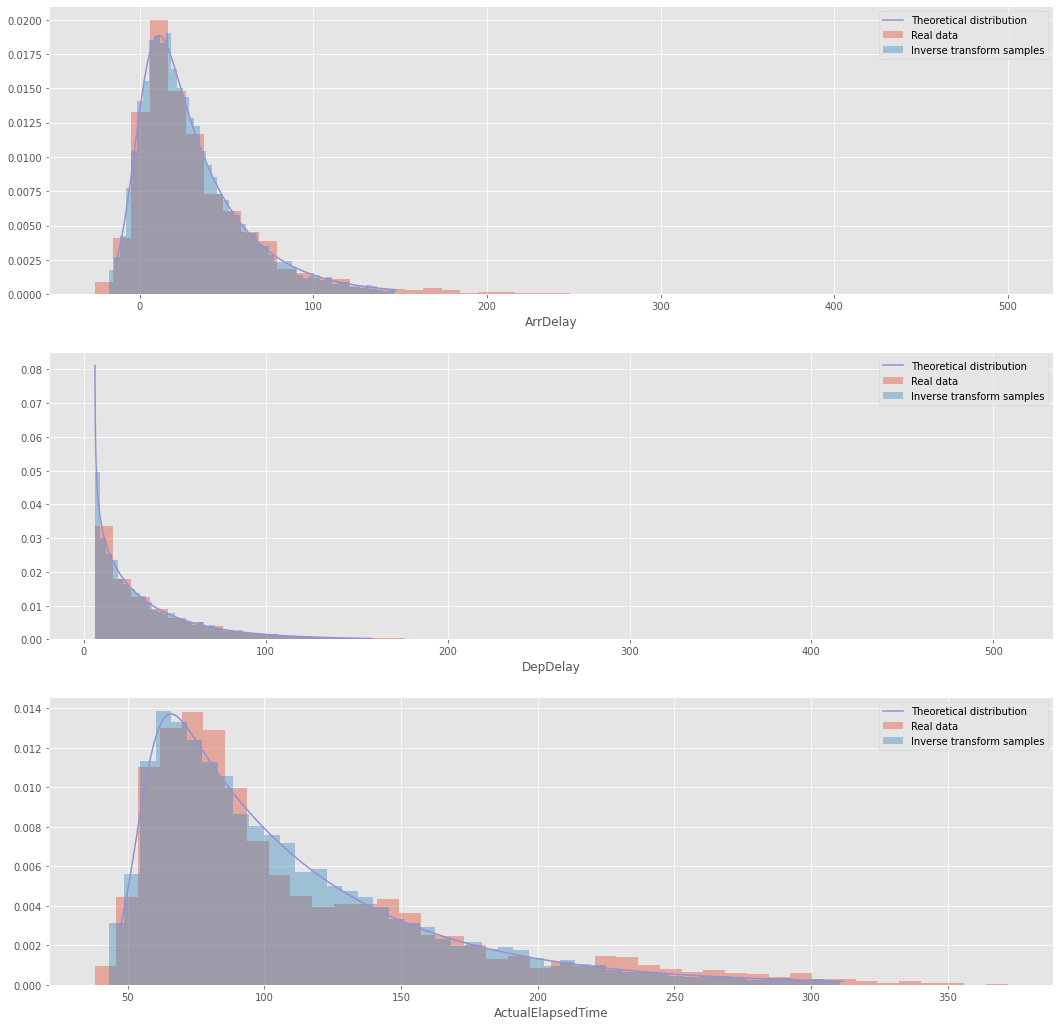

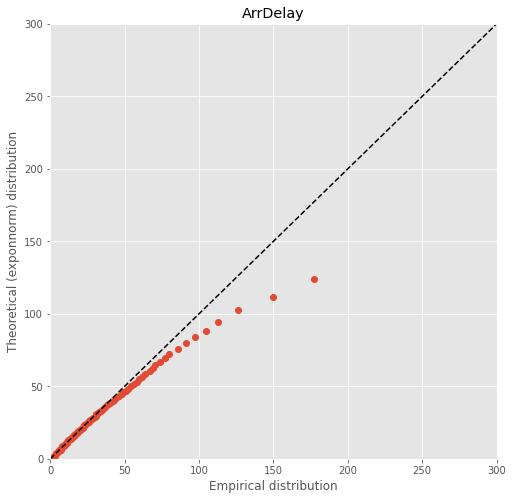

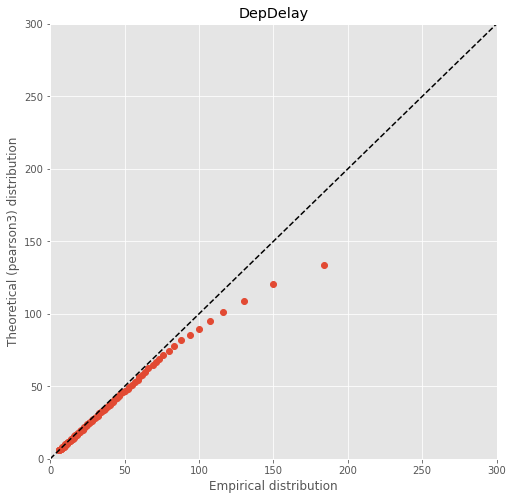

NaNs were deleted


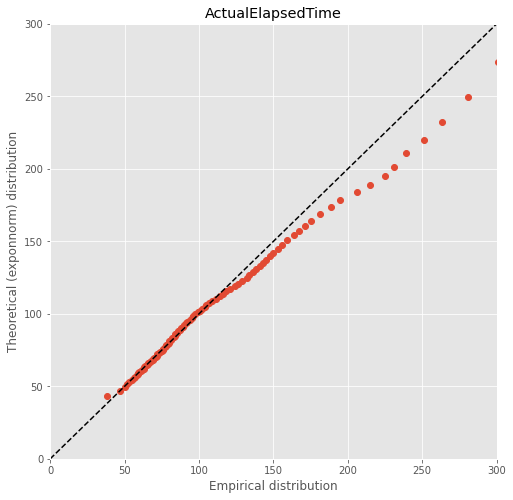

In [31]:
# generating and plottig inverse transform samples

sample_and_plot(dists, its)

/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibil

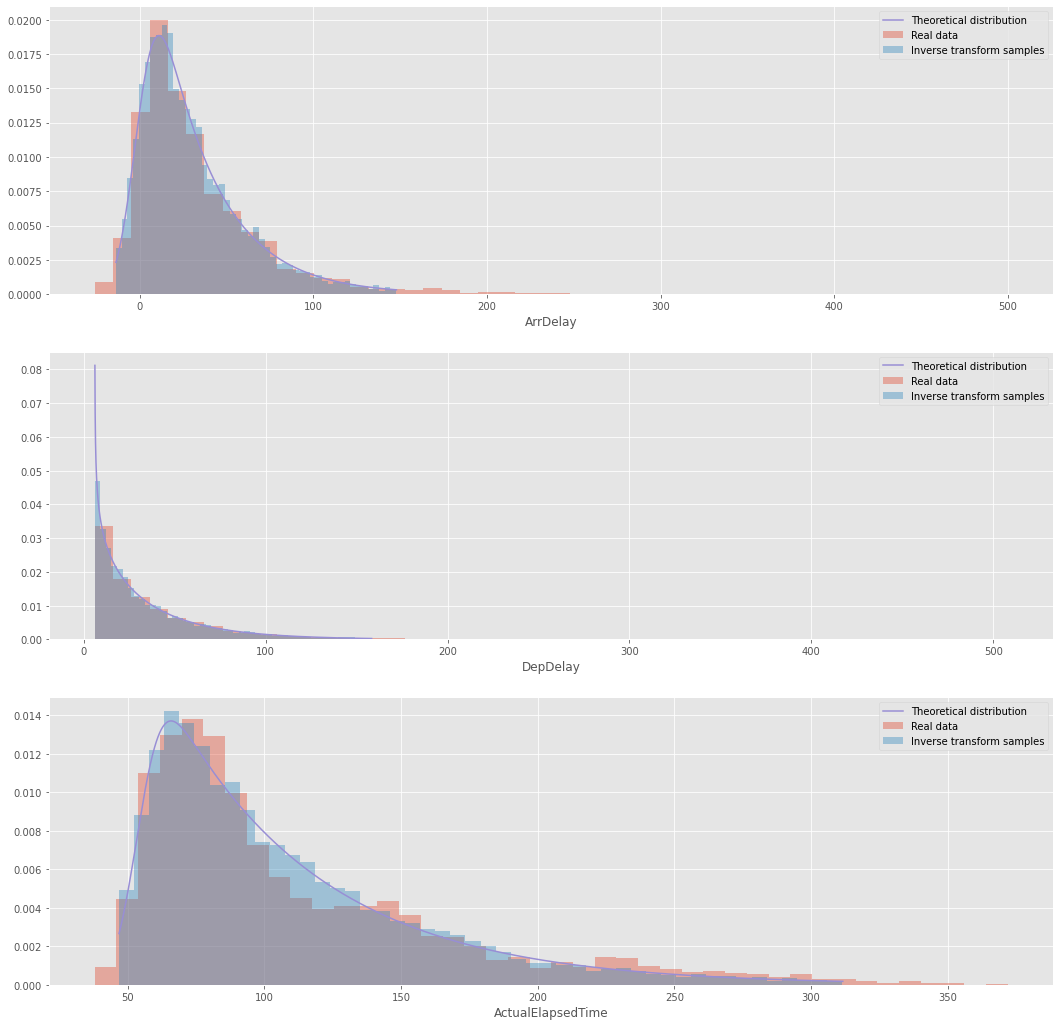

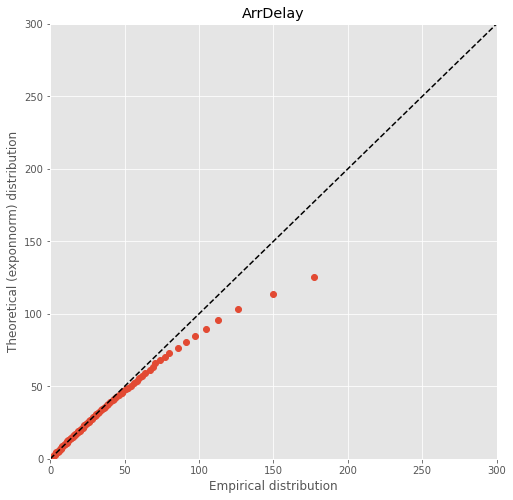

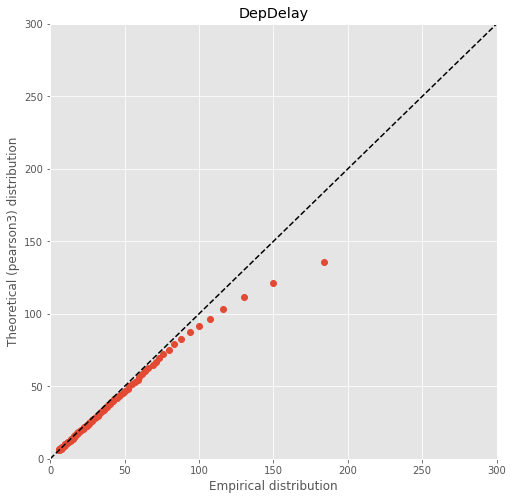

NaNs were deleted


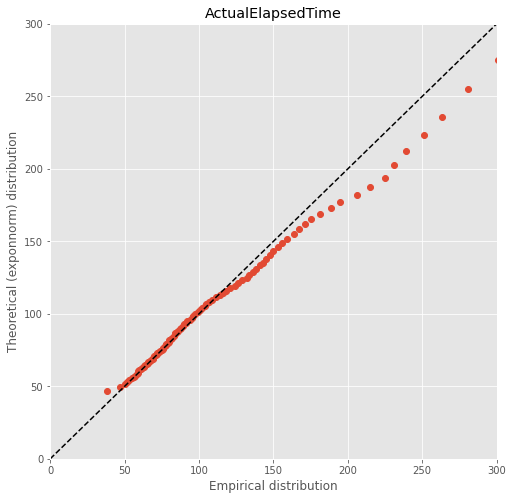

In [32]:
# generating and plottig reject samples

sample_and_plot(dists, reject_sampling)

## Step 3

Estimating the relations between the target variables and prefictors

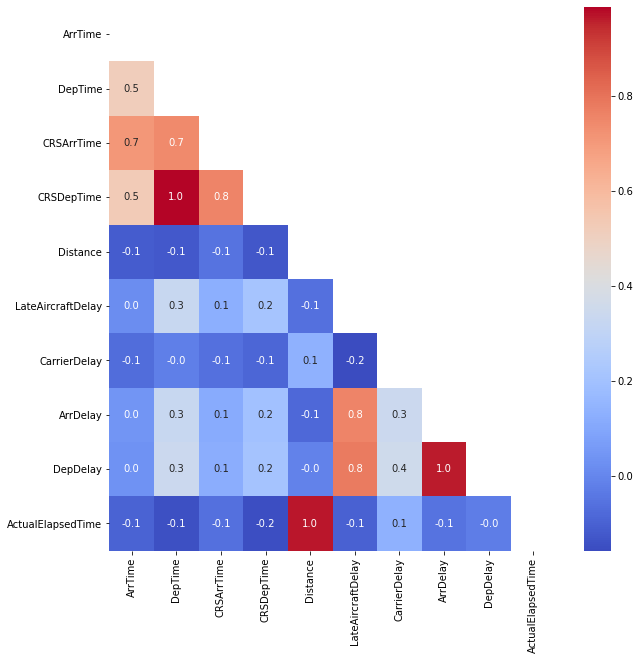

In [24]:
# building a correlation matrix
data_corr = dataset[(Predictors + Targets)]
corr = data_corr.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'coolwarm');

## Step 4

Building a Bayesian network based on multivariet data analisys

In [ ]:
#data preparation

data_keys = ['LateAircraftDelay', 'CarrierDelay', 'ArrDelay', 'DepDelay', 'Distance', 'ActualElapsedTime']
data = dataset[data_keys]
data = data.dropna()

discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")

data_descrete = discretizer.fit_transform(data.values)
data_descrete = pd.DataFrame(data_descrete, columns=data_keys)

data_descrete.head()

,LateAircraftDelay,CarrierDelay,ArrDelay,DepDelay,Distance,ActualElapsedTime
0,1.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,1.0,3.0,3.0
2,2.0,0.0,1.0,2.0,2.0,1.0
3,0.0,0.0,0.0,0.0,3.0,3.0
4,0.0,0.0,0.0,0.0,2.0,2.0


In [ ]:
# modeling edges based on the analisys from step 3

model = BayesianModel([
    ('LateAircraftDelay', 'ArrDelay'),
    ('CarrierDelay', 'ArrDelay'),
    ('ArrDelay', 'DepDelay'),
    ('LateAircraftDelay', 'DepDelay'),
    ('CarrierDelay', 'DepDelay'),
    ('Distance', 'ActualElapsedTime')
])

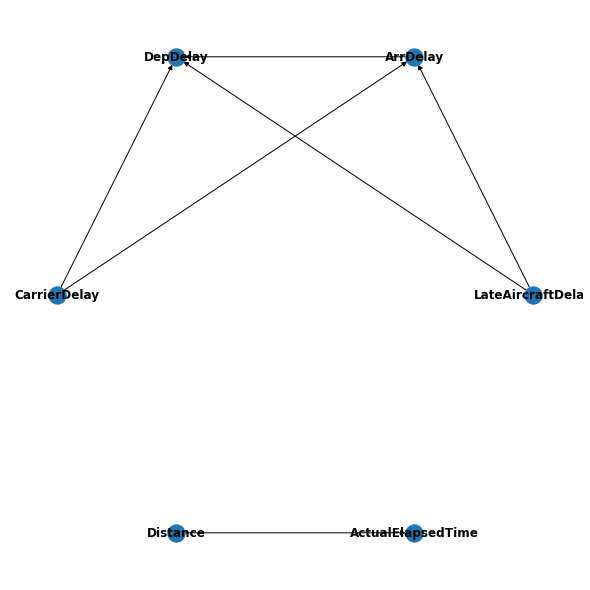

In [ ]:
network = nx.DiGraph()
network.add_edges_from(model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

Generating for node: DepDelay: 100%|██████████| 6/6 [00:00<00:00, 46.07it/s]


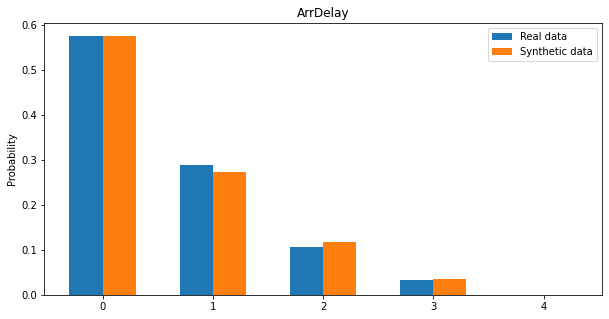

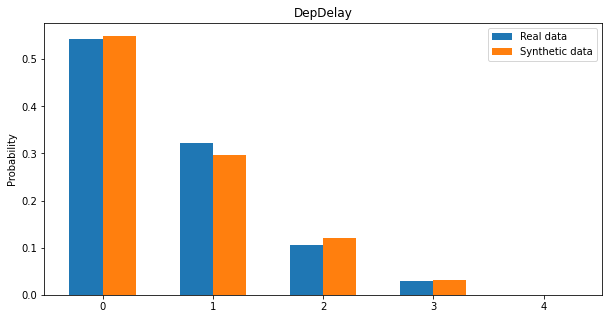

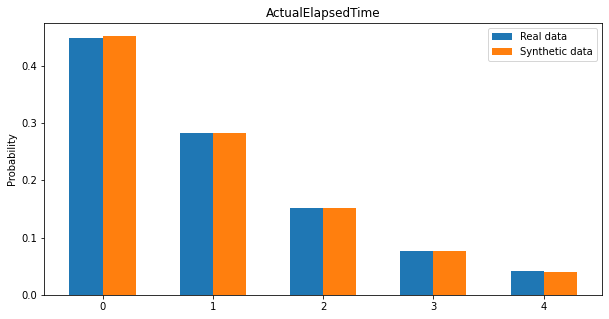

In [ ]:
# traing the model

train_and_plot(model, data_descrete, Targets)

## Step 5

Building a Bayesian network based on the structural learning algorithms

In [ ]:
# hillclimb search algorithm

hc_search = HillClimbSearch(data_descrete, scoring_method=BicScore(data_descrete))
best_model = hc_search.estimate()

  0%|          | 9/1000000 [00:00<11:33:32, 24.03it/s]


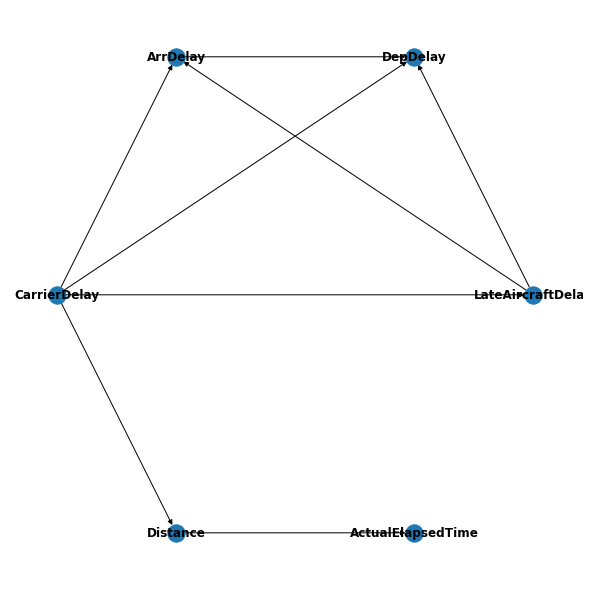

In [ ]:
network = nx.DiGraph()
network.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

Generating for node: DepDelay: 100%|██████████| 6/6 [00:00<00:00, 32.18it/s]


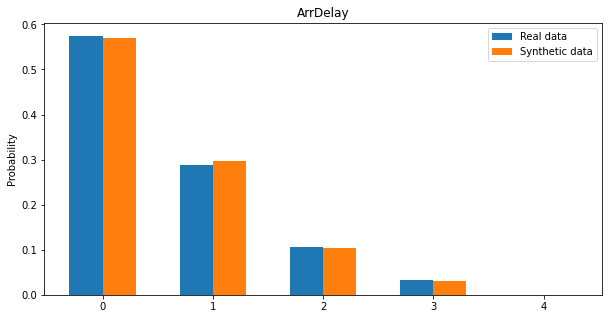

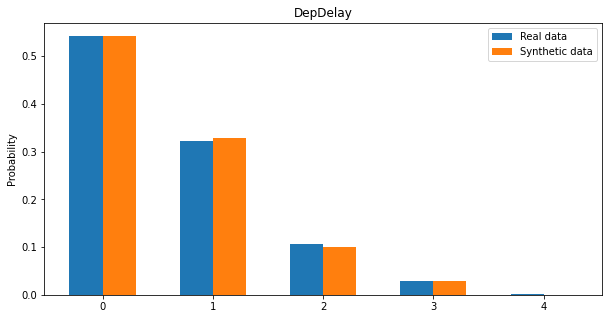

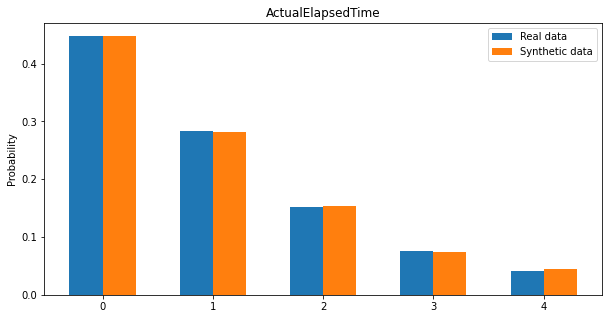

In [ ]:
# training the model

train_and_plot(best_model, data_descrete, Targets)

In [ ]:
# tree search algorithm

tree_search = TreeSearch(data_descrete, root_node='ArrDelay')
best_model = tree_search.estimate()

Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1401.43it/s]


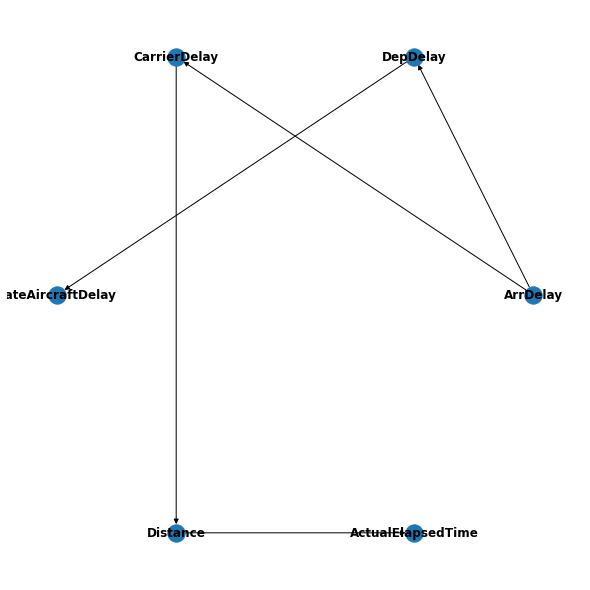

In [ ]:
network = nx.DiGraph()
network.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

Generating for node: LateAircraftDelay: 100%|██████████| 6/6 [00:00<00:00, 36.97it/s]


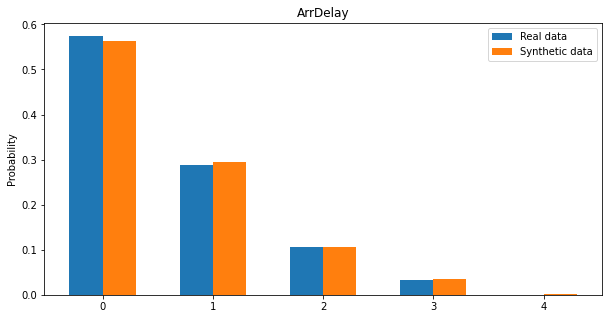

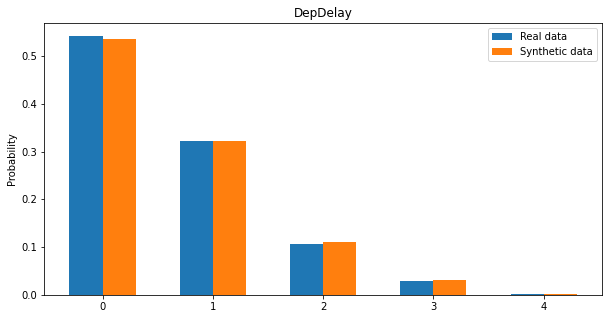

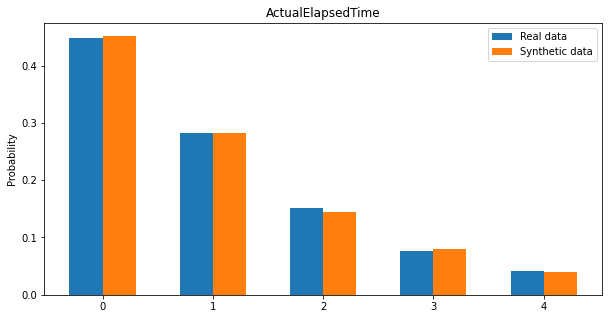

In [ ]:
# training the model

train_and_plot(best_model, data_descrete, Targets)